In [1]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [2]:
train_basalt_dir = os.path.join('/content/Data/train/Basalt')
test_basalt_dir = os.path.join('/content/Data/test/Basalt')

train_highland_dir = os.path.join('/content/Data/train/Highland')
test_highland_dir = os.path.join('/content/Data/test/Highland')

print('total training basalt images:', len(os.listdir(train_basalt_dir)))
print('total training highland images:', len(os.listdir(train_highland_dir)))


total training basalt images: 67
total training highland images: 40


In [3]:
basalt_files = os.listdir(train_basalt_dir)
print(basalt_files[:10])

highland_files = os.listdir(train_highland_dir)
print(highland_files[:10])

['Basalt_Cristobalite_s69-45545.jpg', 'Basalt_Feldspathic_s75-34266.jpg', 'Basalt_Feldspathic_s70-22435.jpg', 'Basalt_Feldspathic_s69-63820.jpg', 'Basalt_Cristobalite_s69-45583.jpg', 'Basalt_Cristobalite_s69-45543.jpg', 'Basalt_Feldspathic_s78-29336.jpg', 'Basalt_Feldspathic_s69-62710.jpg', 'Basalt_Cristobalite_s69-45570.jpg', 'Basalt_Cristobalite_s69-47328.jpg']
['Crustal_Anorthosite_s73-20460.jpg', 'Crustal_Anorthosite_s72-43474.jpg', 'Crustal_Anorthosite_s71-45176.jpg', 'Crustal_Anorthosite_s75-31801.jpg', 'Crustal_Anorthosite_s72-43477.jpg', 'Crustal_Anorthosite_s72-46804.jpg', 'Crustal_Anorthosite_s72-16474.jpg', 'Crustal_Anorthosite_s72-38955.jpg', 'Crustal_Anorthosite_s72-43473.jpg', 'Crustal_Anorthosite_s71-44980.jpg']


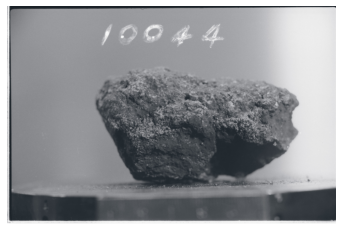

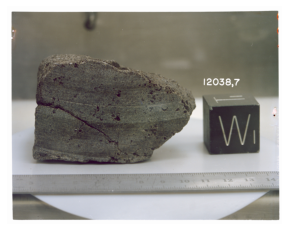

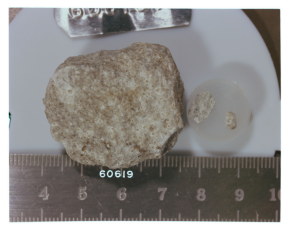

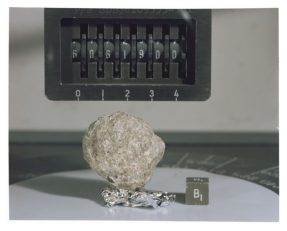

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_basalt = [os.path.join(train_basalt_dir, fname) 
                for fname in basalt_files[pic_index-2:pic_index]] # Adjust the integer to change number of images displayed
next_highland = [os.path.join(train_highland_dir, fname) 
                for fname in highland_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_basalt+next_highland):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img, cmap='gray') # Gray images display as false colours. Set cmap to 'gray'
  plt.axis('Off')
  plt.show()

In [7]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/Data/train"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=15,
	fill_mode="nearest")

VALIDATION_DIR = "/content/Data/test"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(512,512),
	class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR, 
	target_size=(512 ,512),
	class_mode='binary'
)

Found 107 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [10]:
import numpy as np

COUNT_BASALT = len(os.listdir(train_basalt_dir))
COUNT_HIGHLAND = len(os.listdir(train_highland_dir))
TRAIN_IMG_COUNT = COUNT_BASALT + COUNT_HIGHLAND
initial_bias = np.log([COUNT_BASALT /  COUNT_HIGHLAND])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_BASALT + COUNT_HIGHLAND
weight_for_0 = (1 / COUNT_BASALT) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_HIGHLAND) * (TRAIN_IMG_COUNT) / 2.0


class_weight = {0: weight_for_0, 1: weight_for_1}
print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))



Initial bias: 0.51581
Weight for class 0: 0.80
Weight for class 1: 1.34


In [15]:
IMAGE_SIZE = [512, 512]
def create_model():
  base_model = tf.keras.applications.Xception(input_shape=(512, 512, 3),
                                                include_top=False,
                                                weights='imagenet')
    
  base_model.trainable = False
    
  model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  return model

model = create_model()

In [16]:
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)

In [17]:
model.compile(
        optimizer='adam',
        loss="binary_crossentropy",
        metrics=['accuracy'],
    )
history = model.fit(
    train_generator,
    epochs=500,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weight
)

Epoch 1/500
4/4 [==============================] - 128s 32s/step - loss: 0.7063 - accuracy: 0.5888 - val_loss: 0.3470 - val_accuracy: 0.9000
Epoch 2/500
4/4 [==============================] - 127s 32s/step - loss: 0.4137 - accuracy: 0.8598 - val_loss: 0.1889 - val_accuracy: 0.9750
Epoch 3/500
4/4 [==============================] - 131s 33s/step - loss: 0.2833 - accuracy: 0.8879 - val_loss: 0.1009 - val_accuracy: 1.0000
Epoch 4/500
4/4 [==============================] - 131s 33s/step - loss: 0.1845 - accuracy: 0.9720 - val_loss: 0.0684 - val_accuracy: 1.0000
Epoch 5/500
4/4 [==============================] - 129s 32s/step - loss: 0.1213 - accuracy: 0.9813 - val_loss: 0.0472 - val_accuracy: 1.0000
Epoch 6/500
4/4 [==============================] - 129s 32s/step - loss: 0.0895 - accuracy: 0.9907 - val_loss: 0.0266 - val_accuracy: 1.0000
Epoch 7/500
4/4 [==============================] - 131s 33s/step - loss: 0.0846 - accuracy: 0.9813 - val_loss: 0.0227 - val_accuracy: 1.0000
Epoch 8/500
4

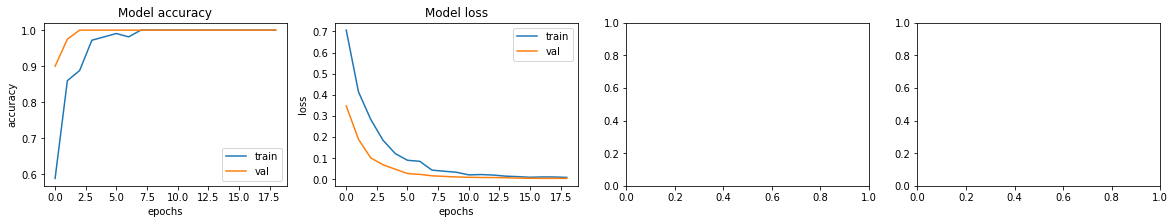

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])